In [1]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob 
import random
import os

## Install Ultralytics Package

In [2]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.4/595.4 kB 15.6 MB/s eta 0:00:00


## Download the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir ./datasets
!unzip /content/drive/MyDrive/EE443_track1.zip -d ./datasets

Streaming output truncated to the last 5000 lines.
  inflating: ./datasets/EE443_track1/c075/img/00322.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00332.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00399.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00404.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00445.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00454.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00552.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00564.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00574.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00578.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00605.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00636.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00651.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00665.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00668.jpg  
  inflating: ./datasets/EE443_track1/c075/img/00692.jpg  
  inflating: ./datase

In [ ]:
!git clone https://github.com/KaiyangZhou/deep-person-reid.git

%cd /content/deep-person-reid
!pwd

!pip3 install -r requirements.txt

!pip3 install pytorch torchvision cudatoolkit=9.0 -c pytorch

!python3 setup.py develop

Cloning into 'deep-person-reid'...
remote: Enumerating objects: 9876, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 9876 (delta 8), reused 14 (delta 7), pack-reused 9851
Receiving objects: 100% (9876/9876), 9.56 MiB | 20.11 MiB/s, done.
^C
[Errno 2] No such file or directory: '/content/deep-person-reid'
/content
/content
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_r

In [ ]:
!cp /content/drive/MyDrive/aic_emb_extract.py /content/deep-person-reid/torchreid

In [ ]:
#h 1080 w 1920
#make numbers in a nice format
#num is the number we want to convert 
#length is the desired output num length
def format_numbers(num, length):
  str_num = str(num)
  if (len(str_num) < length):
    num_zero = length - len(str_num)
    str_num = "0" * num_zero + str_num
  return str_num

In [ ]:
import csv
import pandas as pd
def prepare_labels_folder(path):
  #image weight and height
  w = 1920
  h = 1080

  #yolo has a strict requirement on this. Please don't modify the last "labels"
  label_path = path + "/labels"

  #make directory
  if not (os.path.exists(label_path)):
    os.makedirs(label_path)

  #read table
  df = pd.read_csv(f"{path}/label.txt", header = None)
  df = df.loc[:, :5]

  #create annotation for each image
  for i in range(18010):
    #get image name
    num = format_numbers(i, 5)
    filename = f"{num}.txt"
    img_label_path = f"{label_path}/{filename}"

    #get labels of this frame only
    frame_label = df.loc[df.iloc[:, 0] == i]

    #make everything in coco format
    coco_format = []
    for j in range(frame_label.shape[0]):
      line = frame_label.iloc[j]
      new_line = [0]
      new_line.append((line[2] + line[4] / 2) / w)
      new_line.append((line[3] + line[5] / 2) / h)
      new_line.append(line[4] / w)
      new_line.append(line[5] / h)
      coco_format.append(new_line)

    #write annotation file
    with open(img_label_path, "w", newline = "") as f:
      csv.writer(f, delimiter=' ').writerows(coco_format)

In [ ]:
#train dataset(can be more)
path = "/content/datasets/EE443_track1/c071"
prepare_labels_folder(path)

In [ ]:
path = "/content/datasets/EE443_track1/c072"
prepare_labels_folder(path)

In [ ]:
path = "/content/datasets/EE443_track1/c073"
prepare_labels_folder(path)

In [ ]:
#val dataset
path = "/content/datasets/EE443_track1/c074"
prepare_labels_folder(path)

In [ ]:
!mkdir /content/datasets/train
!mkdir /content/datasets/train/images
!mkdir /content/datasets/train/labels

In [ ]:
import shutil

root = "/content/datasets/EE443_track1"
# code to move from /img folder to /images instead so that YOLOv8 works properly
for i in range(0, 18010, 3):
  num = format_numbers(i, 5)
  if (i % 500 == 0):
    print(i)
  for cmr in range(71, 74):
    image_path = os.path.join(root, f"c0{cmr}", "img", f"{num}.jpg")
    label_path = os.path.join(root, f"c0{cmr}", "labels", f"{num}.txt")
    image_name = int(num) + cmr - 71
    image_name = format_numbers(image_name, 5)
    image_destination = os.path.join("/content/datasets/train/images", f"{image_name}.jpg")
    label_destination = os.path.join("/content/datasets/train/labels", f"{image_name}.txt")
    shutil.copy(image_path, image_destination)
    shutil.copy(label_path, label_destination)

0
1500
3000
4500
6000
7500
9000
10500
12000
13500
15000
16500
18000


In [ ]:
source_folder = '/content/datasets/EE443_track1/c074/img'  
destination_folder = '/content/datasets/train/val/images' 

shutil.copytree(source_folder, destination_folder)

source_folder = '/content/datasets/EE443_track1/c074/labels'  
destination_folder = '/content/datasets/train/val/labels' 

shutil.copytree(source_folder, destination_folder)

'/content/datasets/train/val/labels'

In [ ]:
os.makedirs('datasets', exist_ok=True)

In [ ]:
%cd datasets

/content/datasets


In [ ]:
%cd ..

/content


## Visualize Images from the Dataset

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))
                
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    #all_images.extend(glob.glob(image_paths+'/*.JPG'))
    
    all_images.sort()

    num_images = len(all_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[3:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

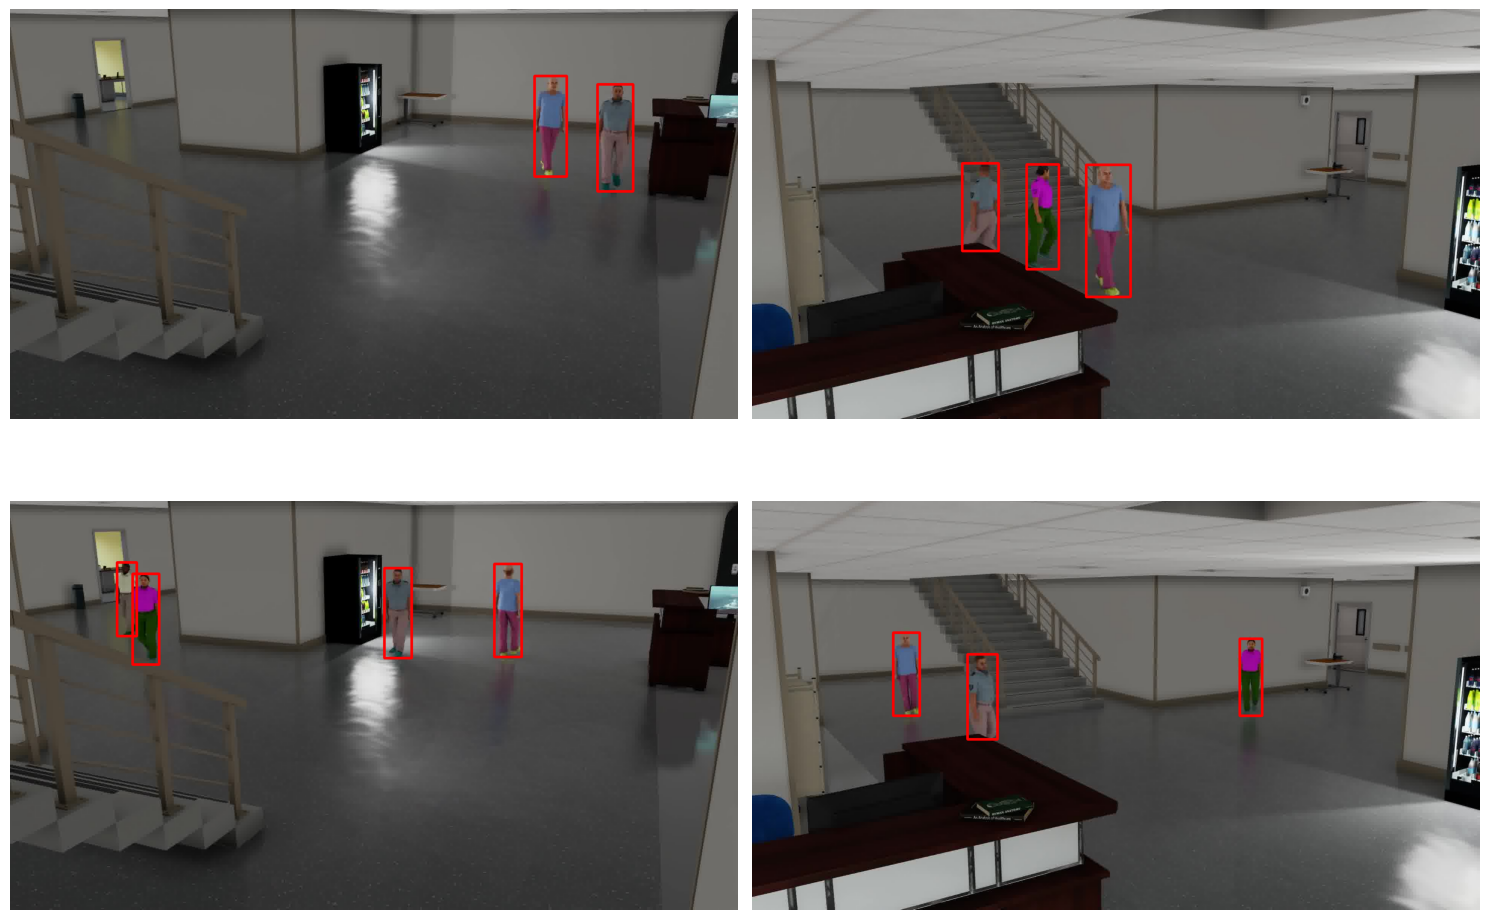

In [ ]:
# Visualize a few training images.
#remember to replace img with images. This is the yolo format requirement
plot(
    image_paths="/content/datasets/train/images", 
    label_paths="/content/datasets/train/labels",
    num_samples=4,
)

## Dataset YAML File

In [ ]:
# %%writefile pothole_v8.yaml
# path: 'pothole_dataset_v8/'
# train: 'train/images'
# val: 'valid/images'

# # class names
# names: 
#   0: 'pothole'

%%writefile tracking.yaml
path: 'train/'
train: 'images'
val: 'val/images'

# class names
names: 
  0: 'person'

Writing tracking.yaml


## YOLOv8 Nano Training

In [ ]:
# Sample training for 5 epoch.
EPOCHS = 1
!yolo task=detect mode=train model=yolov8n.pt imgsz=1280 data=tracking.yaml epochs={EPOCHS} batch=8 name=yolov8n_v8_50e

Ultralytics YOLOv8.0.114 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=tracking.yaml, epochs=1, patience=50, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=Fa

## Evaluation on Validation Images

In [ ]:
!yolo task=detect mode=val model=runs/detect/yolov8n_v8_50e/weights/best.pt name=yolov8n_eval data=tracking.yaml

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/yolo/cfg/__init__.py", line 371, in entrypoint
    model = YOLO(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/yolo/engine/model.py", line 107, in __init__
    self._load(model, task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/yolo/engine/model.py", line 156, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 552, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 492, in torch_safe_load
    return torch.load(file, map_location='cpu'), file  # load
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 791, in load
    with _open_file_like(f,

## Inference on Validation Images

In [ ]:
%cd /content/

!yolo task=detect \
mode=predict \
model=drive/MyDrive/best_2epo.pt \
source=datasets/EE443_track1/c075/images \
imgsz=1280 \
name=yolov8n_v8_50e_infer1280 \
hide_labels=True

/content
WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.0.114 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients

image 1/18010 /content/datasets/EE443_track1/c075/images/00000.jpg: 736x1280 3 persons, 49.2ms
image 2/18010 /content/datasets/EE443_track1/c075/images/00001.jpg: 736x1280 3 persons, 12.3ms
image 3/18010 /content/datasets/EE443_track1/c075/images/00002.jpg: 736x1280 3 persons, 12.3ms
image 4/18010 /content/datasets/EE443_track1/c075/images/00003.jpg: 736x1280 3 persons, 12.3ms
image 5/18010 /content/datasets/EE443_track1/c075/images/00004.jpg: 736x1280 3 persons, 12.3ms
image 6/18010 /content/datasets/EE443_track1/c075/images/00005.jpg: 736x1280 3 persons, 12.3ms
image 7/18010 /content/datasets/EE443_track1/c075/images/00006.jpg: 736x1280 3 persons, 12.3ms
image 8/18010 /content/datasets/EE443_tra

## Visualize Validation Results

In [ ]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

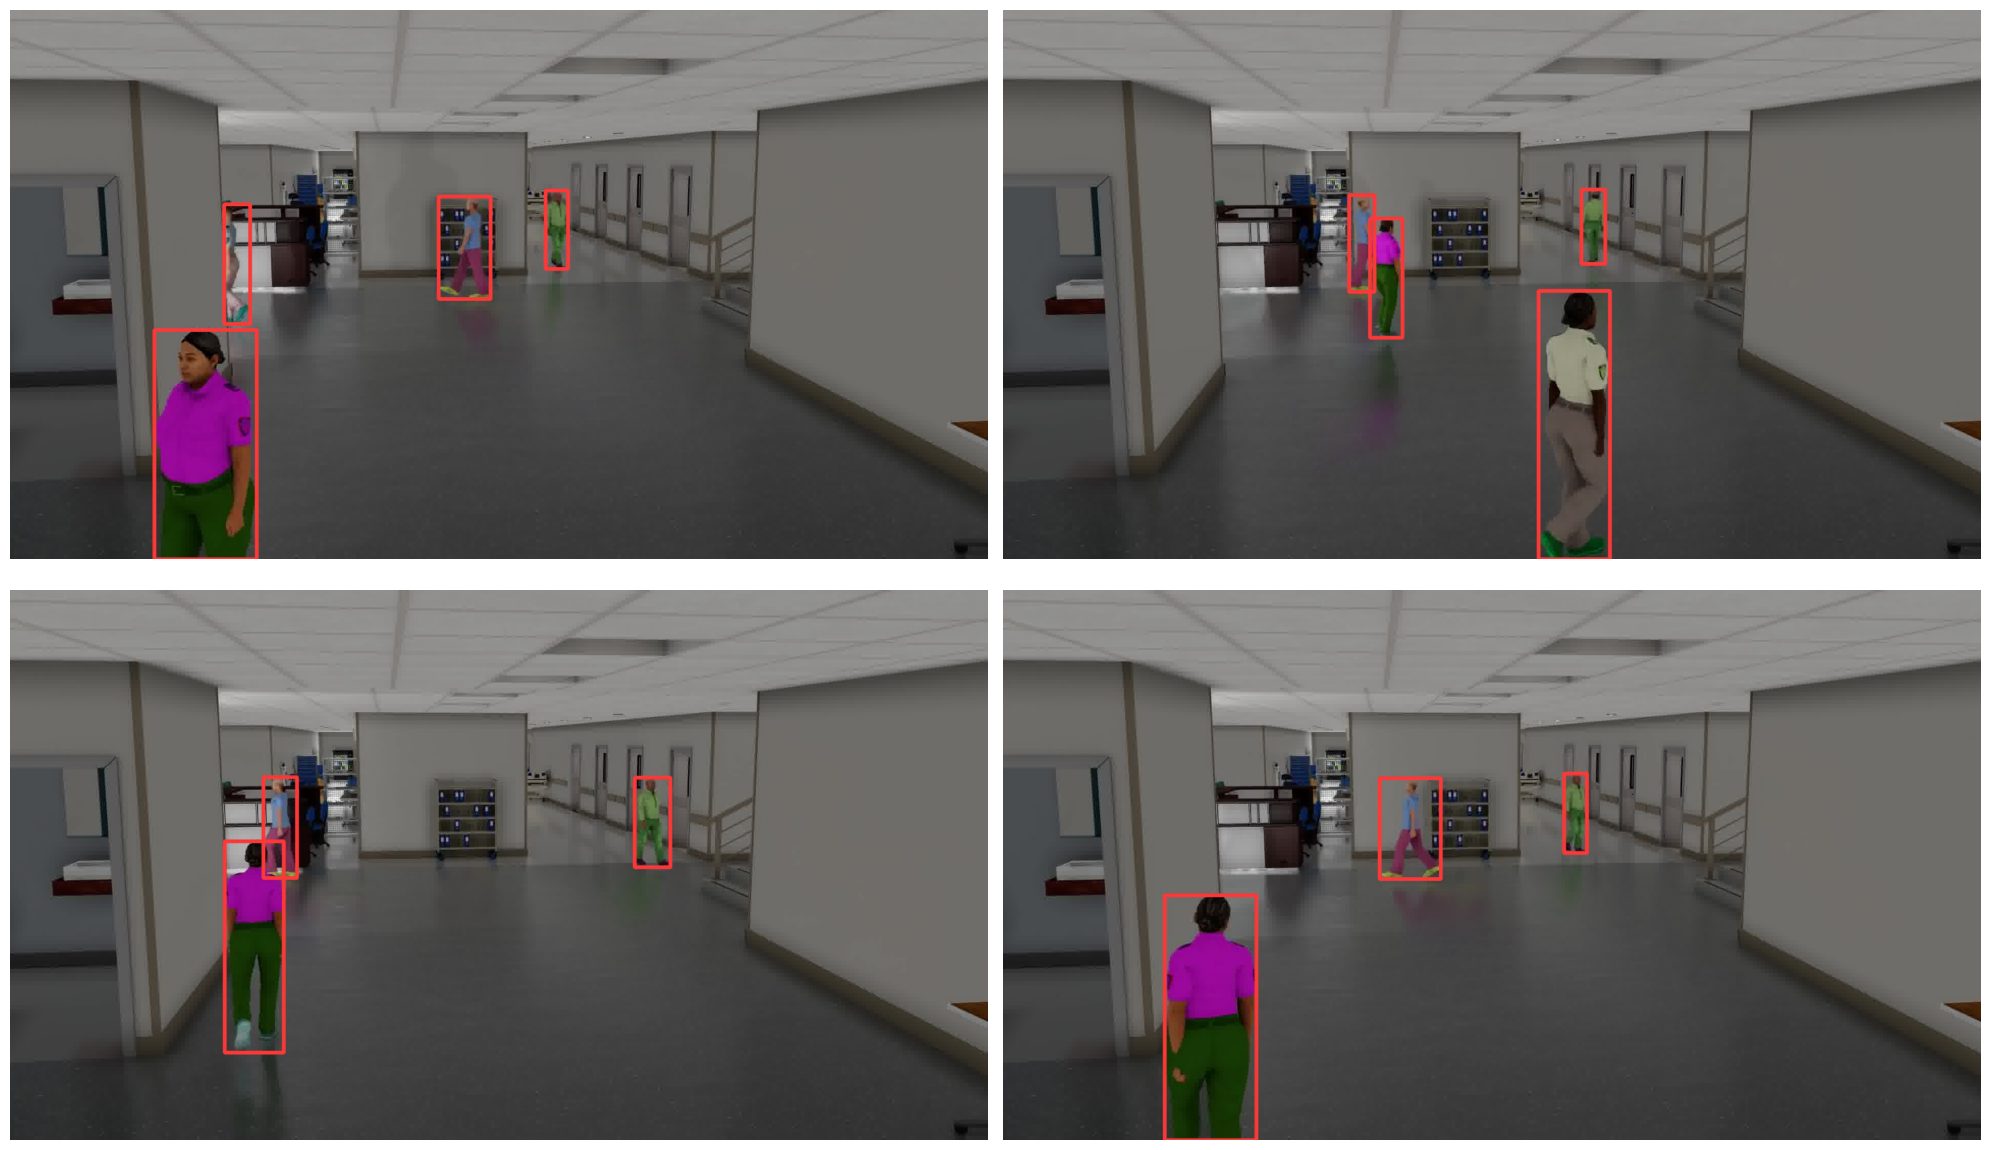

In [ ]:
visualize('runs/detect/yolov8n_v8_50e_infer1280/')

#GENERATE A VIDEO

# Manually change requirements.txt to have onnx = 1.12.0
Please change both lines of onnx and onnxruntime within the ByteTrack/requirements.txt to ==1.12.0 like in the screenshot below. Rerun this cell after this change.

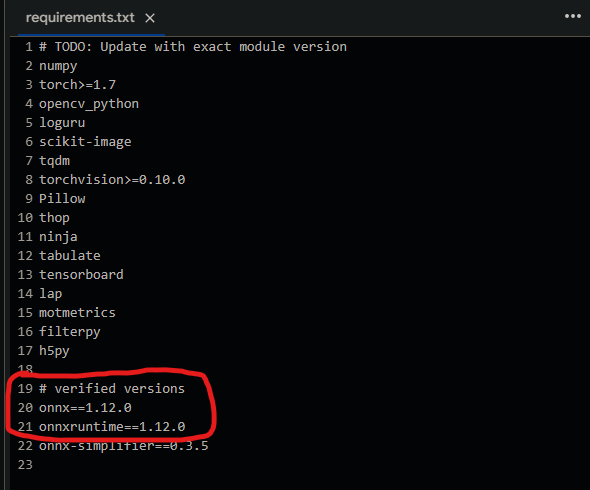

In [5]:
%cd /content
!git clone https://github.com/ifzhang/ByteTrack.git
%cd /content/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.12.0/onnx==1.12.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112
!pip install -q loguru lap
!pip install thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"/content/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [ ]:
SOURCE_VIDEO_PATH = "/content/datasets/EE443_track1/c075/video.mp4"
TARGET_VIDEO_PATH = "/content/result_video.mp4"
file_path = '/content/drive/MyDrive/DIY_result661.txt'

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

Exception: ignored

In [ ]:
from ultralytics import YOLO
model = YOLO("/content/drive/MyDrive/best_2epo.pt")

In [ ]:
from typing import List

import numpy as np

#method to load our generated result file from main.py into a 2D array
def load_tracking_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                values = line.split(',')
                values = [float(value) for value in values]
                data.append(values)
    return data

def readResultFile(file_path):
    result_data = load_tracking_data(file_path)
    # sort results by frame number
    result_data = sorted(result_data, key=lambda x: x[2])
    #sort each result into a map where the frame number is the key
    frame_sorted_results = {x[2]: [y for y in result_data if y[2] == x[2]] for x in result_data}
    #below sorts each tracking id into a map where the frame number is the key
    sorted_tracker_ids = [[row[2], row[1]] for row in result_data]
    frame_id_mapping = {x[0]: [y[1] for y in sorted_tracker_ids if y[0] == x[0]] for x in sorted_tracker_ids}
    return frame_id_mapping

# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

# Below cell only generates detections, does not have correct labels
Only use the below cell to generate detections.txt for the first time. This will not generate the correct tracking ID. Once you get the detections.txt and the embeddings.npy files, run main.py using those files to get results.txt and use that with the cell below

In [ ]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        #mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        #detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        with open('/content/detections.txt', 'a') as f:
          for j in range(len(detections.tracker_id)):
            id = detections.tracker_id[j]
            xyxy = detections.xyxy[j]
            confidence = detections.confidence[j]
            f.write(f"{i},{id},{xyxy[0]},{xyxy[1]},{xyxy[2]},{xyxy[3]},{confidence}\n")
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} person {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        #line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        #line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

# Run below cell AFTER you have results.txt
The cell below will assign the correct tracking ID to each person, but will only work once results.txt is uploaded to colab using the correct filepath and filename as specified in the file_path variable.

In [ ]:
from tqdm.notebook import tqdm
import csv
results_map = readResultFile(file_path)
# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    i = 0
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        boxes = results_map[i]
        print(boxes)
        file_xyxy = np.array([[row[3], row[4], row[3]+row[5], row[4]+row[6]] for row in boxes])
        file_tracking_id = np.array([[row[1]] for row in boxes]).flatten()
        detections = Detections(
            xyxy=file_xyxy,
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int),
            tracker_id=file_tracking_id
        )
        # filtering out detections with unwanted classes
        #mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        #detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        with open('/content/detections.txt', 'a') as f:
          for j in range(len(detections.tracker_id)):
            id = detections.tracker_id[j]
            xyxy = detections.xyxy[j]
            confidence = detections.confidence[j]
            f.write(f"{i},{id},{xyxy[0]},{xyxy[1]},{xyxy[2]},{xyxy[3]},{confidence}\n")

        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} person {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        #line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        #line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)
        i += 1

  0%|          | 0/18010 [00:00<?, ?it/s]


0: 736x1280 3 persons, 94.4ms
Speed: 11.4ms preprocess, 94.4ms inference, 2.4ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 17.0ms
Speed: 11.4ms preprocess, 17.0ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 10.5ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)


[[         75           1           0      444.66      390.42      52.651      235.92          -1          -1]
 [         75           5           0      1145.6      424.14      69.696      265.79          -1          -1]
 [         75           2           0      1031.2      345.67      26.028      122.18          -1          -1]]
[[     444.66      390.42      497.31      626.35]
 [     1145.6      424.14      1215.3      689.94]
 [     1031.2      345.67      1057.2      467.85]]
[          1           5           2]
[[         75           1           1      444.72      390.85      52.598      235.59          -1          -1]
 [         75           5           1      1145.7      424.03      69.372      265.32          -1          -1]
 [         75           2           1      1031.1      345.54      26.048      121.98          -1          -1]]
[[     444.72      390.85      497.31      626.44]
 [     1145.7      424.03      1215.1      689.34]
 [     1031.1      345.54      1057.2 


0: 736x1280 3 persons, 12.3ms
Speed: 9.9ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.6ms
Speed: 12.9ms preprocess, 12.6ms inference, 3.2ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 9.3ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)



[[         75           1           3       444.3      391.63      54.486      232.41          -1          -1]
 [         75           5           3      1146.8      424.38      67.279      265.01          -1          -1]
 [         75           2           3      1030.8      345.08      28.524      120.68          -1          -1]]
[[      444.3      391.63      498.78      624.04]
 [     1146.8      424.38        1214       689.4]
 [     1030.8      345.08      1059.3      465.76]]
[          1           5           2]
[[         75           1           4      444.03      391.82      58.781       232.3          -1          -1]
 [         75           5           4      1145.7      424.98      66.736      263.33          -1          -1]
 [         75           2           4      1029.9      345.15      27.419      121.66          -1          -1]]
[[     444.03      391.82      502.81      624.12]
 [     1145.7      424.98      1212.5       688.3]
 [     1029.9      345.15      1057.3 

0: 736x1280 3 persons, 12.3ms
Speed: 9.8ms preprocess, 12.3ms inference, 3.3ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 8.4ms preprocess, 12.3ms inference, 2.3ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.4ms
Speed: 8.3ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 8.4ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)


[[         75           1           6      447.75      394.14      69.099      229.95          -1          -1]
 [         75           5           6      1137.5      423.08      67.089       264.3          -1          -1]
 [         75           2           6      1029.6      345.62      28.986      119.95          -1          -1]]
[[     447.75      394.14      516.84      624.08]
 [     1137.5      423.08      1204.6      687.38]
 [     1029.6      345.62      1058.6      465.56]]
[          1           5           2]
[[         75           1           7      450.77      394.33       72.69      229.05          -1          -1]
 [         75           5           7      1132.8      423.13      68.001      262.15          -1          -1]
 [         75           2           7      1028.7      347.31      30.531      119.11          -1          -1]]
[[     450.77      394.33      523.46      623.38]
 [     1132.8      423.13      1200.8      685.28]
 [     1028.7      347.31      1059.2 


0: 736x1280 3 persons, 12.3ms
Speed: 8.1ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 8.5ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 8.1ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 10.5ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)


[[         75           1          10       451.5      395.34      89.945      224.65          -1          -1]
 [         75           5          10      1120.5      424.95      83.193      260.78          -1          -1]
 [         75           2          10      1027.3      345.12      34.238      120.44          -1          -1]]
[[      451.5      395.34      541.44         620]
 [     1120.5      424.95      1203.7      685.73]
 [     1027.3      345.12      1061.5      465.56]]
[          1           5           2]
[[         75           1          11      451.43      395.17      94.534      225.83          -1          -1]
 [         75           5          11        1118      425.34      85.016      261.17          -1          -1]
 [         75           2          11      1026.6      344.86       34.94      120.04          -1          -1]]
[[     451.43      395.17      545.96         621]
 [       1118      425.34        1203      686.52]
 [     1026.6      344.86      1061.5 


0: 736x1280 3 persons, 12.4ms
Speed: 8.4ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 8.8ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 9.0ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)



[[         75           1          14       451.1      393.72      94.393      226.86          -1          -1]
 [         75           5          14      1111.7      428.27      81.947      268.21          -1          -1]
 [         75           2          14      1023.5      344.95      38.269      122.04          -1          -1]]
[[      451.1      393.72      545.49      620.58]
 [     1111.7      428.27      1193.6      696.48]
 [     1023.5      344.95      1061.7      466.99]]
[          1           5           2]
[[         75           1          15      452.05      393.88      97.814      224.43          -1          -1]
 [         75           5          15      1110.7      429.63       76.89      269.63          -1          -1]
 [         75           2          15      1025.4      344.97      36.339      121.79          -1          -1]]
[[     452.05      393.88      549.86      618.31]
 [     1110.7      429.63      1187.6      699.26]
 [     1025.4      344.97      1061.7 

0: 736x1280 3 persons, 12.3ms
Speed: 8.0ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 10.1ms preprocess, 12.3ms inference, 2.5ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 8.3ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.5ms
Speed: 9.3ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)


[[         75           1          17      476.39      392.96      81.439      228.75          -1          -1]
 [         75           5          17      1106.3      428.89      74.406      273.66          -1          -1]
 [         75           2          17      1025.6      346.67      35.716      120.88          -1          -1]]
[[     476.39      392.96      557.83      621.71]
 [     1106.3      428.89      1180.7      702.56]
 [     1025.6      346.67      1061.4      467.56]]
[          1           5           2]
[[         75           1          18      484.63      391.35      75.493       230.9          -1          -1]
 [         75           5          18      1100.6       430.4        77.6      273.33          -1          -1]
 [         75           2          18        1025      346.35      36.328      121.37          -1          -1]]
[[     484.63      391.35      560.12      622.25]
 [     1100.6       430.4      1178.2      703.73]
 [       1025      346.35      1061.3 


0: 736x1280 3 persons, 12.3ms
Speed: 10.6ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 8.8ms preprocess, 12.3ms inference, 2.4ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 15.1ms
Speed: 10.7ms preprocess, 15.1ms inference, 2.4ms postprocess per image at shape (1, 3, 1280, 1280)



[[         75           1          21       499.8      389.68       79.04      232.42          -1          -1]
 [         75           5          21      1085.8       430.7      84.693      273.03          -1          -1]
 [         75           2          21      1023.6      345.74      36.779      126.28          -1          -1]]
[[      499.8      389.68      578.84      622.11]
 [     1085.8       430.7      1170.5      703.73]
 [     1023.6      345.74      1060.4      472.03]]
[          1           5           2]
[[         75           1          22      505.85      391.42      77.879      231.32          -1          -1]
 [         75           5          22      1076.6      430.55      91.523      274.21          -1          -1]
 [         75           2          22      1023.6      346.07      36.371      125.13          -1          -1]]
[[     505.85      391.42      583.73      622.75]
 [     1076.6      430.55      1168.1      704.76]
 [     1023.6      346.07      1059.9 

0: 736x1280 3 persons, 12.3ms
Speed: 10.4ms preprocess, 12.3ms inference, 4.1ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 9.1ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 8.0ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.2ms
Speed: 6.5ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)



[[         75           1          24      513.05      393.66      108.82      226.85          -1          -1]
 [         75           5          24      1063.7      432.81      99.571       274.8          -1          -1]
 [         75           2          24      1023.3      346.96      36.369      126.42          -1          -1]]
[[     513.05      393.66      621.87      620.51]
 [     1063.7      432.81      1163.3      707.61]
 [     1023.3      346.96      1059.6      473.38]]
[          1           5           2]
[[         75           1          25      513.06      392.35      112.89      229.39          -1          -1]
 [         75           5          25      1062.6      433.42      98.061      274.11          -1          -1]
 [         75           2          25      1023.1      347.71      36.335      126.21          -1          -1]]
[[     513.06      392.35      625.94      621.75]
 [     1062.6      433.42      1160.7      707.52]
 [     1023.1      347.71      1059.4 

0: 736x1280 3 persons, 12.2ms
Speed: 10.7ms preprocess, 12.2ms inference, 3.2ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.4ms
Speed: 8.4ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.2ms
Speed: 11.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.2ms
Speed: 8.1ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.2ms
Speed: 8.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)


[[         75           1          28      526.54      390.19      103.87      233.74          -1          -1]
 [         75           5          28      1059.9      435.19      93.504      283.36          -1          -1]
 [         75           2          28      1022.5      349.18      36.983      124.15          -1          -1]]
[[     526.54      390.19      630.41      623.93]
 [     1059.9      435.19      1153.4      718.55]
 [     1022.5      349.18      1059.5      473.34]]
[          1           5           2]
[[         75           1          29      535.95      389.32      94.766      234.72          -1          -1]
 [         75           5          29      1061.4      436.24      90.406      284.02          -1          -1]
 [         75           2          29      1022.6      349.79      36.944      123.51          -1          -1]]
[[     535.95      389.32      630.72      624.04]
 [     1061.4      436.24      1151.8      720.26]
 [     1022.6      349.79      1059.5 


0: 736x1280 3 persons, 12.3ms
Speed: 9.4ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 7.3ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 10.6ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.2ms
Speed: 5.6ms preprocess, 12.2ms inference, 2.4ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms


[[         75           1          33      576.77      391.88      67.114      235.73          -1          -1]
 [         75           5          33      1054.3      438.08       83.15      289.06          -1          -1]
 [         75           2          33      1023.8      347.49      35.385      125.88          -1          -1]]
[[     576.77      391.88      643.89      627.61]
 [     1054.3      438.08      1137.5      727.14]
 [     1023.8      347.49      1059.2      473.37]]
[          1           5           2]
[[         75           1          34      580.91      390.23      76.514      236.51          -1          -1]
 [         75           5          34      1049.1      438.87      83.114       287.4          -1          -1]
 [         75           2          34      1023.1       349.1      36.159      124.97          -1          -1]]
[[     580.91      390.23      657.42      626.74]
 [     1049.1      438.87      1132.2      726.27]
 [     1023.1       349.1      1059.2 

Speed: 6.5ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.2ms
Speed: 6.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 9.9ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.2ms
Speed: 7.6ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.2ms
Speed: 6.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)


[[         75           1          37      585.49      392.77      130.63      231.01          -1          -1]
 [         75           5          37      1032.1      439.51      93.542       294.7          -1          -1]
 [         75           2          37      1022.4      348.46      37.577      126.62          -1          -1]]
[[     585.49      392.77      716.12      623.78]
 [     1032.1      439.51      1125.7      734.21]
 [     1022.4      348.46        1060      475.08]]
[          1           5           2]
[[         75           1          38      586.06      392.07      135.59      231.03          -1          -1]
 [         75           5          38      1027.8      440.93      94.961      296.82          -1          -1]
 [         75           2          38      1022.3      349.23      37.806      128.25          -1          -1]]
[[     586.06      392.07      721.65       623.1]
 [     1027.8      440.93      1122.7      737.76]
 [     1022.3      349.23      1060.1 


0: 736x1280 3 persons, 12.3ms
Speed: 10.1ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.2ms
Speed: 7.9ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 8.6ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)



[[         75           1          41      592.36      390.55       135.8      236.23          -1          -1]
 [         75           5          41      1021.9       440.3      97.777      301.73          -1          -1]
 [         75           2          41      1022.2       349.9      38.237       128.2          -1          -1]]
[[     592.36      390.55      728.16      626.77]
 [     1021.9       440.3      1119.7      742.03]
 [     1022.2       349.9      1060.4       478.1]]
[          1           5           2]
[[         75           1          42      602.21      390.85      123.52      237.58          -1          -1]
 [         75           5          42        1021         443      97.271      303.79          -1          -1]
 [         75           2          42        1022      350.79          38      127.52          -1          -1]]
[[     602.21      390.85      725.74      628.43]
 [       1021         443      1118.3      746.79]
 [       1022      350.79        1060 

0: 736x1280 3 persons, 12.3ms
Speed: 9.6ms preprocess, 12.3ms inference, 4.7ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 12.1ms preprocess, 12.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 8.5ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.4ms
Speed: 7.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)



[[         75           1          45      644.54       392.1      82.215      232.06          -1          -1]
 [         75           5          45      1021.9      443.86       93.78      309.95          -1          -1]
 [         75           2          45      1021.5      351.54      38.199      129.88          -1          -1]]
[[     644.54       392.1      726.75      624.16]
 [     1021.9      443.86      1115.7      753.82]
 [     1021.5      351.54      1059.7      481.42]]
[          1           5           2]
[[         75           1          46      663.73       391.4      62.162      231.99          -1          -1]
 [         75           5          46      1023.8      444.19      90.779       312.6          -1          -1]
 [         75           2          46      1021.1      351.18      38.541      129.92          -1          -1]]
[[     663.73       391.4      725.89       623.4]
 [     1023.8      444.19      1114.6      756.79]
 [     1021.1      351.18      1059.7 

0: 736x1280 3 persons, 12.3ms
Speed: 7.8ms preprocess, 12.3ms inference, 2.8ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 8.8ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 6.5ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 10.1ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms


[[         75           1          49      680.02       390.9      102.17      229.48          -1          -1]
 [         75           5          49      1010.7       447.2      97.062      313.67          -1          -1]
 [         75           2          49      1019.3      352.42      37.436         129          -1          -1]]
[[     680.02       390.9      782.19      620.38]
 [     1010.7       447.2      1107.8      760.87]
 [     1019.3      352.42      1056.7      481.41]]
[          1           5           2]
[[         75           1          50      679.05      391.17      118.64      227.99          -1          -1]
 [         75           5          50      1007.6      448.28      97.638      315.24          -1          -1]
 [         75           2          50      1018.2      352.35      37.679      129.48          -1          -1]]
[[     679.05      391.17      797.68      619.16]
 [     1007.6      448.28      1105.3      763.52]
 [     1018.2      352.35      1055.9 

Speed: 8.9ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 8.5ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.2ms
Speed: 7.9ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.2ms
Speed: 7.9ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 13.2ms
Speed: 8.1ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)


[[         75           1          53      681.72      389.85      136.11      225.87          -1          -1]
 [         75           5          53       980.3       449.7      115.53      313.22          -1          -1]
 [         75           2          53      1016.9      350.69      37.522      122.93          -1          -1]]
[[     681.72      389.85      817.83      615.72]
 [      980.3       449.7      1095.8      762.92]
 [     1016.9      350.69      1054.5      473.62]]
[          1           5           2]
[[         75           1          54      683.36      389.99      135.17      227.28          -1          -1]
 [         75           5          54      976.27      449.33      117.87       316.1          -1          -1]
 [         75           2          54      1016.8      350.16      38.119      117.81          -1          -1]]
[[     683.36      389.99      818.54      617.27]
 [     976.27      449.33      1094.1      765.43]
 [     1016.8      350.16      1054.9 


0: 736x1280 3 persons, 12.3ms
Speed: 7.3ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.3ms
Speed: 8.0ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.2ms
Speed: 6.6ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)



[[         75           1          57      707.31      390.55      110.09      229.18          -1          -1]
 [         75           5          57      979.06      450.93      103.67       327.7          -1          -1]
 [         75           2          57      1018.1      349.92      36.187      108.46          -1          -1]]
[[     707.31      390.55       817.4      619.73]
 [     979.06      450.93      1082.7      778.63]
 [     1018.1      349.92      1054.3      458.38]]
[          1           5           2]
[[         75           1          58      722.89      390.18       95.83      228.64          -1          -1]
 [         75           5          58      979.85      453.43      101.36      329.85          -1          -1]
 [         75           2          58      1016.4      349.71      37.399      109.26          -1          -1]]
[[     722.89      390.18      818.72      618.83]
 [     979.85      453.43      1081.2      783.29]
 [     1016.4      349.71      1053.8 

0: 736x1280 3 persons, 12.8ms
Speed: 8.6ms preprocess, 12.8ms inference, 2.1ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 12.2ms
Speed: 7.5ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)


[[         75           1          61      766.97      391.04      57.318      229.76          -1          -1]
 [         75           5          61       973.6      455.36       94.02      326.62          -1          -1]
 [         75           2          61      1014.4       349.1      38.832      132.44          -1          -1]]
[[     766.97      391.04      824.29       620.8]
 [      973.6      455.36      1067.6      781.98]
 [     1014.4       349.1      1053.3      481.54]]
[          1           5           2]
[[         75           1          62      772.37      390.38      70.696       228.9          -1          -1]
 [         75           5          62      967.73      456.93      93.204      331.97          -1          -1]
 [         75           2          62      1013.4      349.23      39.915      133.83          -1          -1]
 [         75           4          62      1434.9      394.12      23.743      158.42          -1          -1]]
[[     772.37      390.38    

ValueError: ignored